### Imports

In [1]:
from PW_explorer.pwe_nb_helper import ASPRules
from LeanEuler.lean_euler import LeanEuler

In [2]:
%load_ext PWE_NB_Extension

In [3]:
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from IPython.display import Image

### Experiment

#### Taxonomy Alignment Problem Instance

Below we have a simple TAP instance in the CleanTax format

In [4]:
with open('cleanTax_files/abstract4.txt', 'r') as f:
    cleantax_sample_file = f.read().splitlines()
print("\n".join(cleantax_sample_file))

taxonomy 1 Taxonomy1
(A B C D E)

taxonomy 2 Taxonomy2
(A B D F G)

articulation abs abstract
[1.A {is_included_in equals} 2.A]
[1.B equals 2.B]
[1.C {is_included_in overlaps} 2.F]
[1.D equals 2.D]
[1.E {equals overlaps} 2.G]


We use LeanEuler to parse it and create an internal representation of the problem.

In [5]:
rel_desc_dfs, taxonomy_trees = LeanEuler.parse_cleantax(cleantax_sample_file)

In [6]:
rel_desc_dfs

,Node1,Relation,Node2
0,"""1_A""",parent,"""1_B"""
1,"""1_A""",parent,"""1_C"""
2,"""1_A""",parent,"""1_D"""
3,"""1_A""",parent,"""1_E"""
4,"""2_A""",parent,"""2_B"""
5,"""2_A""",parent,"""2_D"""
6,"""2_A""",parent,"""2_F"""
7,"""2_A""",parent,"""2_G"""
8,"""1_A""","<,=","""2_A"""
9,"""1_B""",=,"""2_B"""


In [7]:
taxonomy_trees

{'1': {'1': Node('/1'),
  'A': Node('/1/"1_A"'),
  'B': Node('/1/"1_A"/"1_B"'),
  'C': Node('/1/"1_A"/"1_C"'),
  'D': Node('/1/"1_A"/"1_D"'),
  'E': Node('/1/"1_A"/"1_E"')},
 '2': {'2': Node('/2'),
  'A': Node('/2/"2_A"'),
  'B': Node('/2/"2_A"/"2_B"'),
  'D': Node('/2/"2_A"/"2_D"'),
  'F': Node('/2/"2_A"/"2_F"'),
  'G': Node('/2/"2_A"/"2_G"')}}

In [8]:
# from anytree.exporter import DotExporter
# taxonomy_tree_images = []
# for k in taxonomy_trees.keys():
#     t = DotExporter(taxonomy_trees[k][k])
#     t.to_picture('{}.png'.format(k))
#     taxonomy_tree_images.append(Image('{}.png'.format(k)))
# display(*taxonomy_tree_images)

Using these internal representations, we can visualize the input TAP instance as shown below using a simple function call:

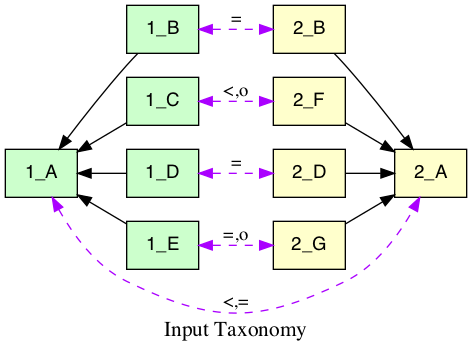

In [9]:
input_constraints_g = LeanEuler.visualize_input(rel_desc_dfs, taxonomy_trees)
draw(input_constraints_g)

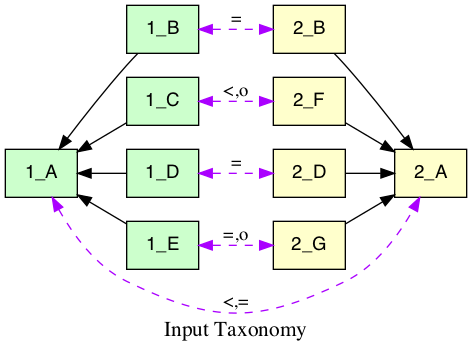

In [10]:
# Directly from the file (skipping the intermediate step)
input_constraints_g = LeanEuler.visualize_input_from_cleantax(cleantax_sample_file)
draw(input_constraints_g)

We can encode this TAP instance in ASP using LeanEuler:

In [11]:
euler_asp_alignment_rules = LeanEuler.gen_asp_rules(rel_desc_dfs, taxonomy_trees, encoding='rcc')
ASPRules("\n".join(euler_asp_alignment_rules))

'%RCC RULES:\n\neq(X,Y) :- eq(X,Z), eq(Z,Y).\ndr(X,Y) :- eq(X,Z), dr(Z,Y).\npp(X,Y) :- eq(X,Z), pp(Z,Y).\npi(X,Y) :- eq(X,Z), pi(Z,Y).\npo(X,Y) :- eq(X,Z), po(Z,Y).\n\ndr(X,Y) :- dr(X,Z), eq(Z,Y).\n1 {dr(X,Y) ; pp(X,Y) ; po(X,Y)} :- dr(X,Z), pp(Z,Y).\n1 {dr(X,Y) ; pi(X,Y) ; po(X,Y)} :- dr(X,Z), pi(Z,Y).\n1 {dr(X,Y) ; pp(X,Y) ; po(X,Y)} :- dr(X,Z), po(Z,Y).\n\npp(X,Y) :- pp(X,Z), eq(Z,Y).\ndr(X,Y) :- pp(X,Z), dr(Z,Y).\npp(X,Y) :- pp(X,Z), pp(Z,Y).\ndr(X,Y) ; pp(X,Y) ; po(X,Y) :- pp(X,Z), po(Z,Y).\n\npi(X,Y) :- pi(X,Z), eq(Z,Y).\n1 {dr(X,Y) ; pi(X,Y) ; po(X,Y)} :- pi(X,Z), dr(Z,Y).\npi(X,Y) :- pi(X,Z), pi(Z,Y).\n1 {pi(X,Y) ; po(X,Y)} :- pi(X,Z), po(Z,Y).\n\npo(X,Y) :- po(X,Z), eq(Z,Y).\n1 {dr(X,Y) ; pi(X,Y) ; po(X,Y)} :- po(X,Z), dr(Z,Y).\n1 {pp(X,Y) ; po(X,Y)} :- po(X,Z), pp(Z,Y).\n1 {dr(X,Y) ; pi(X,Y) ; po(X,Y)} :- po(X,Z), pi(Z,Y).\n\nu(X) :- dr(X,_).\nu(X) :- dr(_,X).\nu(X) :- eq(X,_).\nu(X) :- eq(_,X).\nu(X) :- po(X,_).\nu(X) :- po(_,X).\nu(X) :- pp(X,_).\nu(X) :- pp(_,X).\nu(X) :- pi(X,_).\nu(X) :- pi(_,X).\nu(X) :- bl(_,X).\nu(X) :- bl(X,_).\n\neq(X,X) :- u(X).\npi(X,Y) :- pp(Y,X).\npp(X,Y) :- pi(Y,X).\neq(X,Y) :- eq(Y,X).\npo(X,Y) :- po(Y,X).\ndr(X,Y) :- dr(Y,X).\ndr(Y,Z) :- bl(X,Y), bl(X,Z), Y != Z.\npp(Y,X) :- bl(X,Y).\n\n1 {eq(X,Y) ; dr(X,Y) ; pp(X,Y) ; pi(X,Y) ; po(X,Y)} :- u(X), u(Y), X != Y.\n\n:- eq(X,Y), dr(X,Y).\n:- eq(X,Y), pp(X,Y).\n:- eq(X,Y), pi(X,Y).\n:- eq(X,Y), po(X,Y).\n:- dr(X,Y), pp(X,Y).\n:- dr(X,Y), pi(X,Y).\n:- dr(X,Y), po(X,Y).\n:- pp(X,Y), pi(X,Y).\n:- pp(X,Y), po(X,Y).\n:- pi(X,Y), po(X,Y).\n\n%TAXONOMY DESC RULES\n\nbl("1_A","1_B").\nbl("1_A","1_C").\nbl("1_A","1_D").\nbl("1_A","1_E").\nbl("2_A","2_B").\nbl("2_A","2_D").\nbl("2_A","2_F").\nbl("2_A","2_G").\n1 { pp("1_A","2_A") ; eq("1_A","2_A") }.\neq("1_B","2_B").\n1 { pp("1_C","2_F") ; po("1_C","2_F") }.\neq("1_D","2_D").\n1 { eq("1_E","2_G") ; po("1_E","2_G") }.'

In [12]:
# Directly from the file (short-circuiting)
euler_asp_alignment_rules = LeanEuler.gen_asp_rules(rel_desc_dfs, 
                                                    taxonomy_trees, 
                                                    encoding='mnpw')
ASPRules("\n".join(euler_asp_alignment_rules))

'r(1..24).\n\n% Region Meanings\nin(X, M) :- r(M), concept(X, T, N), N1=N+1, bit(M, T, N1).\nout(X, M) :- r(M), concept(X, T, N), N1=N+1, not bit(M, T, N1).\nin(X, M) :- r(M), concept2(X, _), not out(X, M).\nirs(M) :- in(X, M), out(X, M), r(M), concept2(X, _).\n\n% Region Constraints\nirs(X) :- ir(X, _).\nvrs(X) :- vr(X, _).\nvr(X, X) :- not irs(X), r(X).\nir(X, X) :- not vrs(X), r(X).\n:- vrs(X), irs(X).\n\nconcept2(A, B) :- concept(A,B,_).\n\n% Taxonomy Description\n\n%  Euler Bit\nbit(M, 0, V) :- r(M), M1=M/1, V = M1 \\ 5.\n\n%  Euler Bit\nbit(M, 1, V) :- r(M), M1=M/5, V = M1 \\ 5.\n\nconcept2("1_A", 0).\nconcept("1_B", 0, 0).\nconcept("1_C", 0, 1).\nconcept("1_D", 0, 2).\nconcept("1_E", 0, 3).\nconcept2("2_A", 1).\nconcept("2_B", 1, 0).\nconcept("2_D", 1, 1).\nconcept("2_F", 1, 2).\nconcept("2_G", 1, 3).\n\n% "1_B" isa "1_A"\nir(X, r6) :- in("1_B", X), out("1_A", X).\n:- #count {X : vrs(X), in("1_B", X), in("1_A", X)} = 0.\n\n% "1_C" isa "1_A"\nir(X, r7) :- in("1_C", X), out("1_A", X).\n:- #count {X : vrs(X), in("1_C", X), in("1_A", X)} = 0.\n\n% "1_D" isa "1_A"\nir(X, r8) :- in("1_D", X), out("1_A", X).\n:- #count {X : vrs(X), in("1_D", X), in("1_A", X)} = 0.\n\n% "1_E" isa "1_A"\nir(X, r9) :- in("1_E", X), out("1_A", X).\n:- #count {X : vrs(X), in("1_E", X), in("1_A", X)} = 0.\n\n% "2_B" isa "2_A"\nir(X, r16) :- in("2_B", X), out("2_A", X).\n:- #count {X : vrs(X), in("2_B", X), in("2_A", X)} = 0.\n\n% "2_D" isa "2_A"\nir(X, r17) :- in("2_D", X), out("2_A", X).\n:- #count {X : vrs(X), in("2_D", X), in("2_A", X)} = 0.\n\n% "2_F" isa "2_A"\nir(X, r18) :- in("2_F", X), out("2_A", X).\n:- #count {X : vrs(X), in("2_F", X), in("2_A", X)} = 0.\n\n% "2_G" isa "2_A"\nir(X, r19) :- in("2_G", X), out("2_A", X).\n:- #count {X : vrs(X), in("2_G", X), in("2_A", X)} = 0.\n\n% Coverage for "1_A"\nout("1_A", X) :- out("1_B", X), out("1_C", X), out("1_D", X), out("1_E", X).\n\n% Coverage for "2_A"\nout("2_A", X) :- out("2_B", X), out("2_D", X), out("2_F", X), out("2_G", X).\n\n% "1_B" ! "1_C"\nir(X, r0) :- in("1_B", X), in("1_C", X).\n:- #count {X : vrs(X), in("1_B", X), out("1_C", X)} = 0.\n:- #count {X : vrs(X), in("1_C", X), out("1_B", X)} = 0.\n\n% "1_B" ! "1_D"\nir(X, r1) :- in("1_B", X), in("1_D", X).\n:- #count {X : vrs(X), in("1_B", X), out("1_D", X)} = 0.\n:- #count {X : vrs(X), in("1_D", X), out("1_B", X)} = 0.\n\n% "1_B" ! "1_E"\nir(X, r2) :- in("1_B", X), in("1_E", X).\n:- #count {X : vrs(X), in("1_B", X), out("1_E", X)} = 0.\n:- #count {X : vrs(X), in("1_E", X), out("1_B", X)} = 0.\n\n% "1_C" ! "1_D"\nir(X, r3) :- in("1_C", X), in("1_D", X).\n:- #count {X : vrs(X), in("1_C", X), out("1_D", X)} = 0.\n:- #count {X : vrs(X), in("1_D", X), out("1_C", X)} = 0.\n\n% "1_C" ! "1_E"\nir(X, r4) :- in("1_C", X), in("1_E", X).\n:- #count {X : vrs(X), in("1_C", X), out("1_E", X)} = 0.\n:- #count {X : vrs(X), in("1_E", X), out("1_C", X)} = 0.\n\n% "1_D" ! "1_E"\nir(X, r5) :- in("1_D", X), in("1_E", X).\n:- #count {X : vrs(X), in("1_D", X), out("1_E", X)} = 0.\n:- #count {X : vrs(X), in("1_E", X), out("1_D", X)} = 0.\n\n% "2_B" ! "2_D"\nir(X, r10) :- in("2_B", X), in("2_D", X).\n:- #count {X : vrs(X), in("2_B", X), out("2_D", X)} = 0.\n:- #count {X : vrs(X), in("2_D", X), out("2_B", X)} = 0.\n\n% "2_B" ! "2_F"\nir(X, r11) :- in("2_B", X), in("2_F", X).\n:- #count {X : vrs(X), in("2_B", X), out("2_F", X)} = 0.\n:- #count {X : vrs(X), in("2_F", X), out("2_B", X)} = 0.\n\n% "2_B" ! "2_G"\nir(X, r12) :- in("2_B", X), in("2_G", X).\n:- #count {X : vrs(X), in("2_B", X), out("2_G", X)} = 0.\n:- #count {X : vrs(X), in("2_G", X), out("2_B", X)} = 0.\n\n% "2_D" ! "2_F"\nir(X, r13) :- in("2_D", X), in("2_F", X).\n:- #count {X : vrs(X), in("2_D", X), out("2_F", X)} = 0.\n:- #count {X : vrs(X), in("2_F", X), out("2_D", X)} = 0.\n\n% "2_D" ! "2_G"\nir(X, r14) :- in("2_D", X), in("2_G", X).\n:- #count {X : vrs(X), in("2_D", X), out("2_G", X)} = 0.\n:- #count {X : vrs(X), in("2_G", X), out("2_D", X)} = 0.\n\n% "2_F" ! "2_G"\nir(X, r15) :- in("2_F", X), in("

In [13]:
# Directly from the file (short-circuiting)

# euler_asp_alignment_rules = LeanEuler.gen_asp_rules_from_cleantax(cleantax_sample_file, encoding='mnpw')
# ASPRules("\n".join(euler_asp_alignment_rules))

Once we have an ASP encoding for the TAP instance, we can use ASP reasoner (via LeanEuler/PWE) to find the possible alignments.

In [14]:
pw_rels_dfs, rel_schemas, pw_objs = LeanEuler.generate_pws(euler_asp_alignment_rules)
pw_rels_dfs.keys()

Number of Models: 7


dict_keys(['u_1', 'bl_2', 'pp_2', 'rel_3', 'dr_2', 'eq_2', 'po_2'])

As we can see, in this case we have 7 possible alignments.

We can visualize them using a simple function call to LeanEuler as shown below:

In [15]:
pws_vizs = LeanEuler.visualize_output(pw_rels_dfs, project_name='Sample_Euler_Problem', 
                                      pws_to_visualize=pw_objs)

Number of Models: 1
Number of Models: 1
Number of Models: 1
Number of Models: 1
Number of Models: 1
Number of Models: 1
Number of Models: 1


In [16]:
t=[draw(pws_vizs[i]) for i in pws_vizs.keys()]

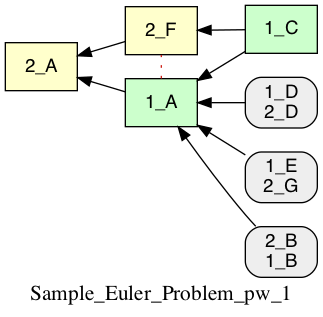

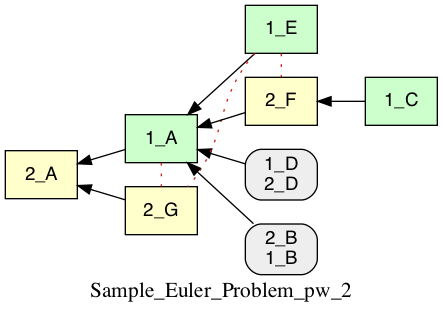

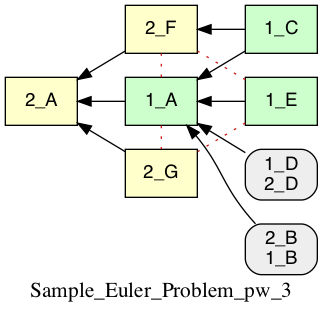

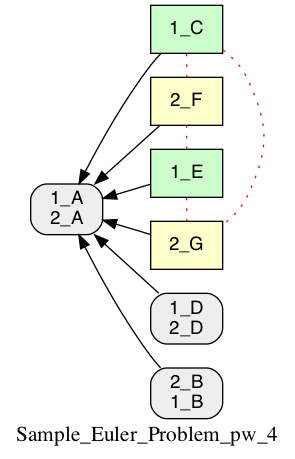

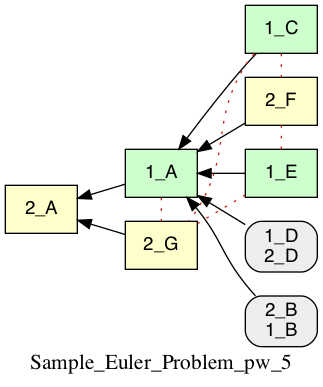

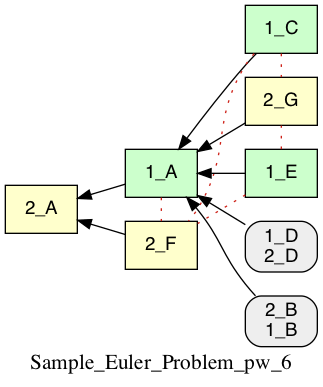

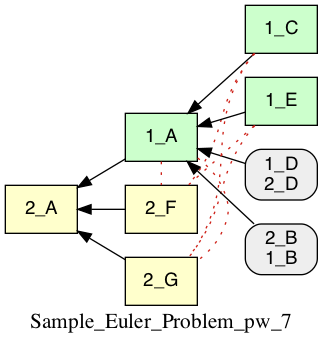

In [17]:
display(*t)